# 线性回归——音乐年代预测
## 目录
一. 概述：音乐年代预测与回归问题  
二. 数据集的加载与展示  
三. 特征筛选与预处理  
四. 线性回归  
五. 多项式回归  
六. 岭回归  

# 一. 概述：音乐年代预测与回归问题
## 1. 音乐年代预测问题  
- 根据一首音乐的音频特征，推测这首音乐的发行年份。
    - 问题的输入：音乐的特征
    - 问题的输出：发行年份（是一个实数）
- 音乐年代预测问题是一个比较典型的***回归问题***。

## 2. 回归问题（regression）  
- 和分类问题一样，回归问题也是以数据的特征为输入，以数据的标签为输出。
- 回归与分类的区别
    - 分类模型的输出是离散的、孤立的类别，比如鸢尾花的种类。
    - 回归模型的输出是连续的**数值**，比如这里的年份可以近似看作是连续的。
    - 分类问题是提供定性的输出，回归问题是提供定量的输出。
- 生活中的回归问题
    - 房屋价格预测
        - 输入一个房屋的地理位置、面积等特征
        - 输出这个房屋的价格
    - 气温预测
        - 输入某个时刻
        - 输出该时刻的气温

接下来，实验正式开始。
- 我们需要首先安装`PrettyTable`模组，它可以帮我们打印好看的表格（如果已安装可忽略）。
- 接着我们导入本课程代码所需要的`python`库（不能在后文的代码中自行import）。

In [26]:
# 安装PrettyTable模组
! pip install PrettyTable

In [2]:
# 导入Python库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import metrics
from sklearn.utils import shuffle
from io import StringIO
import sys
import hdf5_getters  # 和数据集一起放在根目录
import prettytable as pt
sns.set_style('whitegrid')
%matplotlib inline

print('导入成功！')

导入成功！


# 二. 数据集的加载与展示
## 1. 百万歌曲数据集
- 本课程采用的数据集来自于“百万歌曲数据集（Million Song Dataset, MSD）”。
    - 百万歌曲数据集包括了1,000,000首当代流行音乐的音频特征和元数据。
        - 音频特征是对歌曲的音频的数据描述，包括响度、音色、音调等。
        - 歌曲的*元数据*指歌曲名称、演唱者、词曲作者、发行公司、发行年份等信息，它们不能在歌曲的音频中直接体现。
- 每首歌用一个`.h5`文件储存其特征，所有的文件在一个目录树中分布。
    - `.h5`文件使用`HDF5`格式储存数据，是一种层次化的数据储存格式。
    - 本数据集提供了`hdf5_getters.py`模组来读取这种格式的文件（已作为附件提供，也可在数据集官网中下载）。
    - 更多关于`HDF5`格式的知识可以参考维基百科：https://en.wikipedia.org/wiki/Hierarchical_Data_Format
- 更多关于百万歌曲数据集的介绍、示例、下载等，可以参考官网：http://millionsongdataset.com/
    - 原始论文*The Million Song Dataset* http://ismir2011.ismir.net/papers/OS6-1.pdf
- 下面，我们展示其中一首歌的特征。
    - 我们读取一个数据文件，用数据集提供的`hdf5_getters`模组来获取其中包含的特征。
    - 我们首先看一下一个数据文件中包含多少种特征，然后用表格的形式展示出来。

In [3]:
# 2.1 百万歌曲数据集
# 2.1.1 一首歌包括多少种特征
getter_list = list(filter(lambda x: x[:3] == 'get', hdf5_getters.__dict__.keys()))  # 特征的数量就是getter的种类
number_of_features = len(getter_list) 
print(u'一首歌曲的特征数：', number_of_features)

#2.1.2 展示某文件的特征
print('文件TRAAABD128F429CF47.h5中的所有特征：')
file_path = 'TRAAABD128F429CF47.h5' # 数据集中的一个数据文件
file = hdf5_getters.open_h5_file_read(file_path)  # 读取文件

table = pt.PrettyTable()
table.field_names = ["序号", "特征名", "特征类型", "值/数组形状"]
for cnt, key in zip(range(1, number_of_features+1), getter_list):
    func = hdf5_getters.__dict__[key]
    if isinstance(func(file), np.ndarray):  # 如果是数组
        table.add_row([cnt, key[4:], str(type(func(file)))[14:-2], func(file).shape]) # 序号，特征名，特征类型，数组形状
    else:  # 不是数组
        table.add_row([cnt, key[4:], str(type(func(file)))[14:-2], func(file)]) # 序号，特征名，特征类型，特征值
print(table)
file.close()

一首歌曲的特征数： 55
文件TRAAABD128F429CF47.h5中的所有特征：
+------+----------------------------+----------+-----------------------------------------+
| 序号 |           特征名           | 特征类型 |               值/数组形状               |
+------+----------------------------+----------+-----------------------------------------+
|  1   |         num_songs          |  int64   |                    1                    |
|  2   |     artist_familiarity     | float64  |            0.6306300375898077           |
|  3   |     artist_hotttnesss      | float64  |            0.4174996449709784           |
|  4   |         artist_id          |  bytes_  |          b'ARMJAGH1187FB546F3'          |
|  5   |        artist_mbid         |  bytes_  | b'1c78ab62-db33-4433-8d0b-7c8dcf1849c2' |
|  6   |      artist_playmeid       |  int32   |                  22066                  |
|  7   |     artist_7digitalid      |  int32   |                   1998                  |
|  8   |      artist_latitude       | float64  |            

- 从上面的结果可以看出：
    - 每个样本都有55种特征。
    - 从数据类型看，有的特征值是一个实数或字符串，有的特征值是一个array。
    - 有的样本的部分特征值缺失了。（比如这里的song_hotttness，即歌曲热度，是nan，意为无效数据。）

## 2. 数据集的加载
- 在本实验中，我们要使用到百万歌曲数据集中的音频特征和发行年份。我们使用的是*YearPredictionMSD Data Set*。
    - 它是百万歌曲数据集的一个子集，包含了其中的音频特征和年份，由加州大学尔湾分校（UCI）的研究人员创建。
    - 这个数据集没有重复的样本，也没有缺失的数据。
    - 每一个样本都包含90个音频特征。这些特征包括12个平均值和78个协方差。为了时间和空间的效率，我们仅保留前12个音频特征，即12个平均值。
    - 来源：https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd

In [4]:
# 数据集的加载
################################## Question 1 ########################################
# 要求：
#   - 加载数据集year_prediction.csv，保存为变量data，类型：DataFrame 
#   - 将数据集的特征部分另存为变量X，类型：DataFrame
#   - 将数据集的标签部分另存为变量Y，类型：Series
############################## Start of Your code ####################################
data=pd.read_csv('year_prediction.csv')
X=data.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12]]
Y=data['label']


############################### End of Your Code #####################################

assert X.shape[0] == Y.size  # 检验X和Y的样本数是否一致
print('读取成功！')

# 查看数据集的行数和列数
print('数据集中的样本数：', X.shape[0])
print('每个样本的特征数：', X.shape[1])

# 查看数据集的前5个样本
data.head(5) 

读取成功！
数据集中的样本数： 515345
每个样本的特征数： 12


,label,TimbreAvg1,TimbreAvg2,TimbreAvg3,TimbreAvg4,TimbreAvg5,TimbreAvg6,TimbreAvg7,TimbreAvg8,TimbreAvg9,TimbreAvg10,TimbreAvg11,TimbreAvg12
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223


- 可见，数据集中有515345个样本，每个样本除了预测目标year以外，有12个特征。
- 这些特征包括12个平均值（TimbreAvg1~12）。
    - 每一个样本包含每首歌都被分为12个片段（segment），每个片段用一个12维的向量来表示它的音色（timbre）。对每个12维的向量求平均值，那么一首歌可以得到12个平均值。
    
## 3. 数据集的展示
- 我们首先来以10年为一个单位，展示数据集中歌曲年代的分布。

Text(0, 0.5, 'Decade')

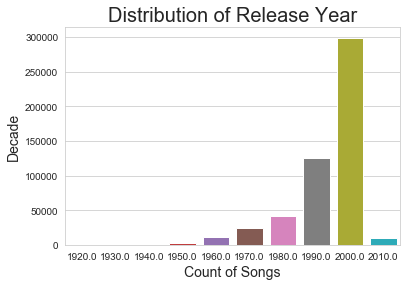

In [5]:
# 每个十年的歌曲数
################################## Question 2 ########################################
# 要求：
#   - 首先根据歌曲年份计算年代，并将歌曲年代作为一个额外的特征decade加入变量data中。
#     - 例如一首歌的发行年份是1986，那么它的decade列的数据应为1980
#   - 绘制一幅统计图，展示每个十年的歌曲数。
# 提示：
#   - 计数和绘图可使用seaborn.countplot()
############################## Start of Your code ####################################
decade=np.zeros(X.shape[0])

for i in range(X.shape[0]):
    decade[i]=int(int(data['label'][i]/10)*10)
    
data.insert(13,'decade',decade)
sns.countplot(x='decade',data=data)



############################### End of Your Code #####################################

plt.title('Distribution of Release Year',fontsize=20)
plt.xlabel('Count of Songs',fontsize=14)
plt.ylabel('Decade',fontsize=14)

- 我们的任务，就是使用这些样本进行训练。
- 我们想要建立起一个回归模型，即对于一个未知的样本：
    - 输入：由12个特征值组成的向量
    - 输出：音乐的发行年代year

# 三. 特征筛选与预处理


## 1. 特征筛选
- 根据第二部分的结果，我们可以发现，在百万歌曲数据集中：
    1. 不是所有特征都是数字，能方便地进行数学计算；
    2. 不是所有特征都与我们的目标（预测年代）密切相关；
- 因此，需要对这些特征进行***特征筛选***，即：保留部分特征作为后续分析的输入。
- 我们采用的数据集YearPredictionMSD Data Set，已对百万歌曲数据集进行了数据筛选。
    - 只保留了和音色timbre有关的特征，然后进行计算，得到平均值和协方差。
    
## 2. 特征的数值分布展示
- 我们观察一下样本中各维度的数值分布情况。
    - 首先看一下各维度的统计数据：平均值、标准差、最小值、25%、50%、75%、最大值

In [6]:
X.describe()

,TimbreAvg1,TimbreAvg2,TimbreAvg3,TimbreAvg4,TimbreAvg5,TimbreAvg6,TimbreAvg7,TimbreAvg8,TimbreAvg9,TimbreAvg10,TimbreAvg11,TimbreAvg12
count,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000
mean,43.387126,1.289554,8.658347,1.164124,-6.553601,-9.521975,-2.391089,-1.793236,3.727876,1.882385,-0.146527,2.546063
std,6.067558,51.580351,35.268585,16.322790,22.860785,12.857751,14.571873,7.963827,10.582861,6.530232,4.370848,8.320190
min,1.749000,-337.092500,-301.005060,-154.183580,-181.953370,-81.794290,-188.214000,-72.503850,-126.479040,-41.631660,-69.680870,-94.041960
25%,39.954690,-26.059520,-11.462710,-8.487500,-20.666450,-18.440990,-10.780600,-6.468420,-2.293660,-2.444850,-2.652090,-2.550060
50%,44.258500,8.417850,10.476320,-0.652840,-6.007770,-11.188390,-2.046670,-1.736450,3.822310,1.783520,-0.097950,2.313700
75%,47.833890,36.124010,29.764820,8.787540,7.741870,-2.388960,6.508580,2.913450,9.961820,6.147220,2.435660,7.360330
max,61.970140,384.065730,322.851430,335.771820,262.068870,166.236890,172.402680,126.741270,146.297950,60.345350,88.020820,87.913240


- 为了直观地展现特征的数值分布，下面绘制每个维度的分布直方图
    - 每一幅图的横坐标代表值的大小，纵坐标代表频数/分度值。

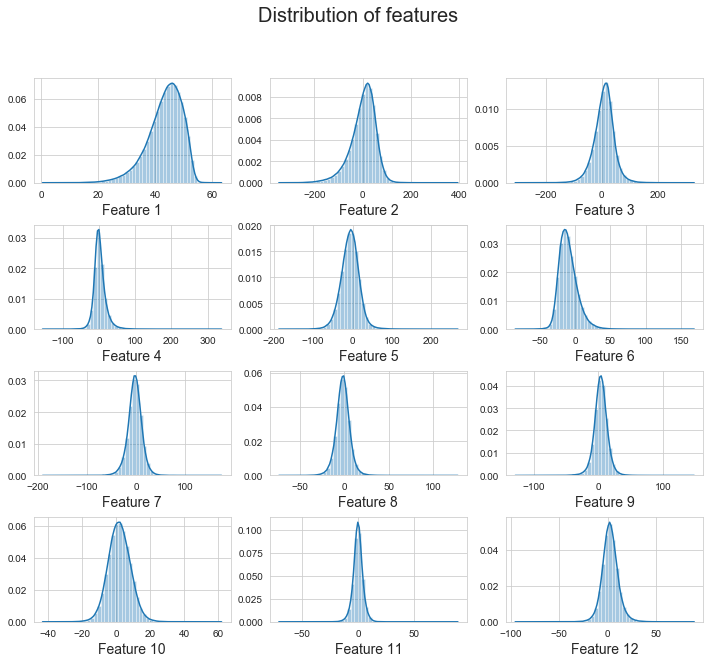

In [7]:
fig = plt.figure(figsize=(12,10))  # 新建一个12*10的画布
fig.suptitle("Distribution of features", fontsize=20)
plt.subplots_adjust(hspace=0.4)
# 画12个子图
for i in range(12):
    ax = plt.subplot(4,3,i+1)
    sns.distplot(X.iloc[:,i])  # 调用seaborn中的直方图
    plt.xlabel(f'Feature {i+1}', fontsize=14)

- 可见：各个维度的数值范围差异是很大的，为此我们需要进行***特征缩放***。

## 3. 特征缩放
- 特征缩放：将各项特征的值缩放到相同或相近的大小范围。
- 为什么要进行特征缩放？
    - 模型在训练时会主要受数值大的特征影响
    - 如果不进行特征缩放，回归分析的训练时间会变长
    - 我们接下来使用的模型对数据的规模特别敏感，不缩放就很难训练
- 特征缩放的方法：
    1. ***标准化（Standardization）***：一般指使数据的均值为0，方差为1
        - 有时也指将数据的数值范围压缩到一个固定的范围，比如$[0, 1]$
    2. ***归一化（Normalization）***：使数据的特征向量缩放到单位长度
- 在本次实验中，我们选用`scikit-learn`中内建的特征缩放方法来处理数据
    - 可以参考 https://scikit-learn.org/stable/modules/preprocessing.html 中6.3.1-3中的介绍

In [8]:
# 3.3 特征缩放
# 使用sklearn.preprocessing模组中的方法，对数据进行标准化
################################### Question 2 #########################################
# 要求：
#   - 对X中的数据进行标准化，将缩放后的数据存为X_scaled，类型：DataFrame
#     - 使用sklearn.preprocessing中的特征缩放方法
# 提示：
#   - 参考上文提到的网址，选一个合适的Scaler
############################### Start of Your Code #####################################
X_scaled = pd.DataFrame(preprocessing.scale(X))
################################ End of Your Code ######################################
# 展示各特征的统计量
X_scaled.describe()

,0,1,2,3,4,5,6,7,8,9,10,11
count,5.153450e+05,5.153450e+05,5.153450e+05,5.153450e+05,5.153450e+05,5.153450e+05,5.153450e+05,5.153450e+05,5.153450e+05,5.153450e+05,5.153450e+05,5.153450e+05
mean,-1.843818e-16,-1.101853e-17,6.831164e-17,2.202472e-16,1.260065e-16,-2.301772e-17,9.820544e-17,-9.673242e-17,1.275889e-16,-1.000020e-16,-1.321897e-18,-3.107836e-18
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-6.862425e+00,-6.560296e+00,-8.780157e+00,-9.517237e+00,-7.672525e+00,-5.620919e+00,-1.275218e+01,-8.878982e+00,-1.230358e+01,-6.663483e+00,-1.590868e+01,-1.160888e+01
25%,-5.657035e-01,-5.302232e-01,-5.705099e-01,-5.912981e-01,-6.173394e-01,-6.936690e-01,-5.757337e-01,-5.870530e-01,-5.689900e-01,-6.626471e-01,-5.732447e-01,-6.125014e-01
50%,1.436122e-01,1.381980e-01,5.154657e-02,-1.113147e-01,2.387631e-02,-1.296040e-01,2.363593e-02,7.130436e-03,8.923323e-03,-1.513959e-02,1.111388e-02,-2.792768e-02
75%,7.328761e-01,6.753442e-01,5.984502e-01,4.670417e-01,6.253278e-01,5.547643e-01,6.107436e-01,5.910085e-01,5.890610e-01,6.530916e-01,5.907754e-01,5.786252e-01
max,3.062687e+00,7.420976e+00,8.908591e+00,2.049944e+01,1.175037e+01,1.366950e+01,1.199530e+01,1.613981e+01,1.347180e+01,8.952672e+00,2.017170e+01,1.026025e+01


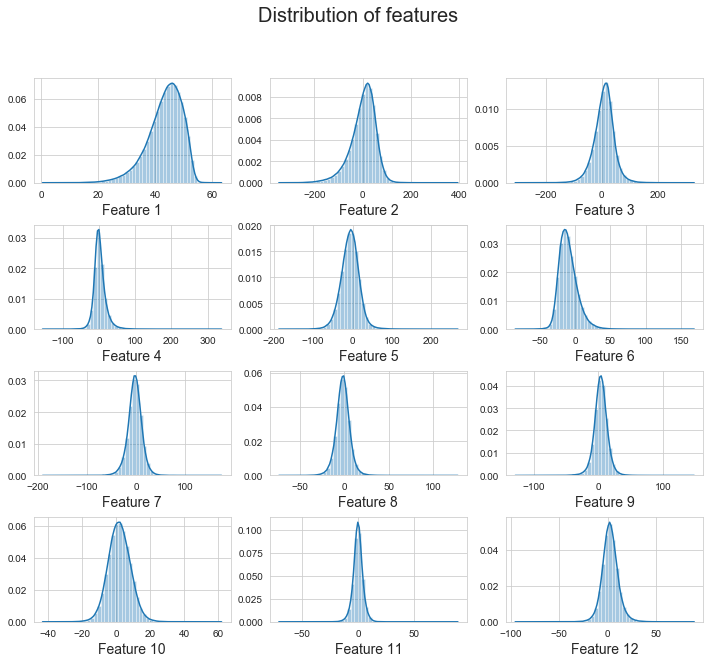

In [9]:
fig = plt.figure(figsize=(12,10))  # 新建一个12*10的画布
fig.suptitle("Distribution of features", fontsize=20)
plt.subplots_adjust(hspace=0.4)
# 画12个子图
for i in range(12):
    ax = plt.subplot(4,3,i+1)
    sns.distplot(X.iloc[:,i])  # 调用seaborn中的直方图
    plt.xlabel(f'Feature {i+1}', fontsize=14)

## 4. 特征展示
- 下面我们尝试直观展示一下不同年代音乐之间的特征差异
    - 随机抽取四个特征，做散点图

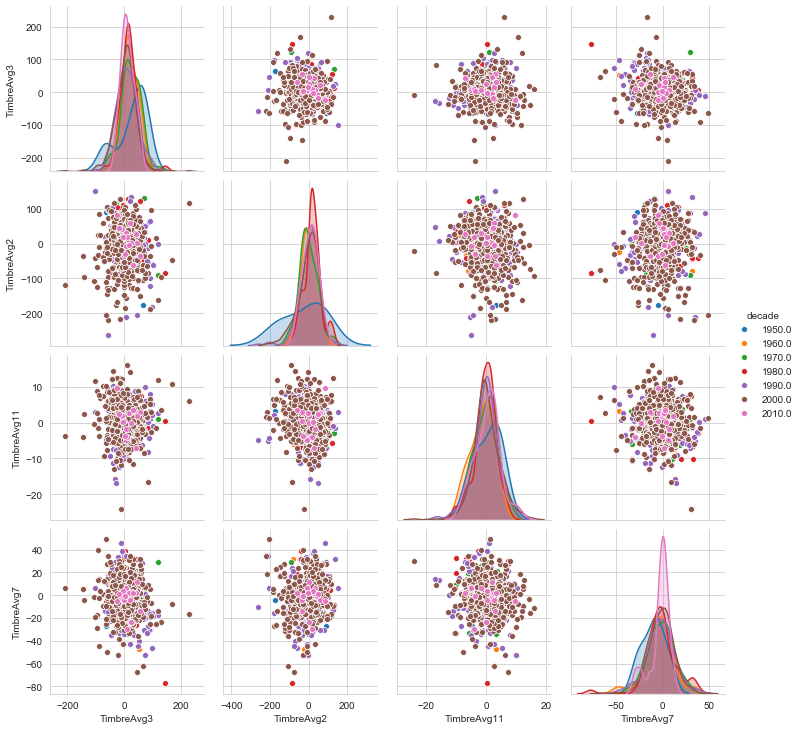

In [10]:
# 3.4 特征展示
X_sample=X.sample(n=4, axis=1)
X_sample['decade']=data['decade']
X_sample=X_sample.sample(1000)
sns.pairplot(data=X_sample, hue='decade', vars=X_sample.columns[:-1])

- 用热力图（heatmap）展现不同年代音乐的特征向量。
    - 我们剔除样本过少的20~40年代音乐，然后从每个年代的音乐中取相同数量，对它们的特征向量求平均值。
    - 颜色越浅代表这一年代音乐的某一平均特征的值越大。

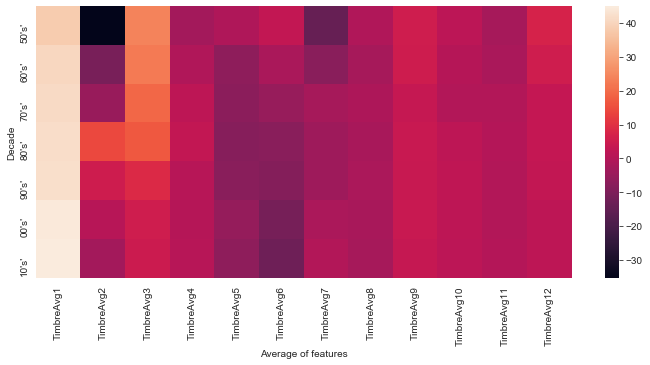

In [11]:
data_t = data[data.decade>1940]  # 剔除40年代及以前
min_samples = data_t.decade.value_counts().min()
decades = data_t.decade.unique()
data_sampled = pd.DataFrame(columns=data_t.columns)

for decade in decades:
    data_sampled = data_sampled.append(data_t[data_t.decade==decade].sample(min_samples))
data_sampled.decade = data_sampled.decade.astype(int)

labels = ["{:02d}'s'".format(l%100) for l in sorted(data_sampled.decade.unique())]
fig, ax = plt.subplots(figsize=(12,5)) 
sns.heatmap(data_sampled.groupby(['decade']).mean(), yticklabels=labels)
plt.ylabel("Decade")
plt.xlabel("Average of features")
plt.show()

## 5. 数据集划分
- 回归问题是一类***监督学习***的问题
    - 监督学习需要有训练数据集
- 我们把数据集划分为***训练数据集***和***测试数据集***
    - 模型仅使用训练集中的数据进行训练
    - 训练完成后，然后在测试集中进行测试
- 一般来说，需要指定训练集和测试集的比例。
    - 本课程采用的数据集推荐的划分是：前463,715个样本为训练集，后51,630个样本为测试集

In [12]:
# 3.5 数据集划分
################################### Question 3 #########################################
# 要求：
#   - 对数据进行数据集划分，要满足前463,715个样本为训练集，后51,630个样本为测试集
#   - 将训练集特征、测试集特征分别存为x_train, x_test，类型：DataFrame
#   - 将训练集目标、测试集目标分别存为y_train, y_test，类型：Series
############################### Start of Your Code #####################################

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X_scaled,Y, test_size = 0.1001853127516518)


################################ End of Your Code ######################################

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(463715, 12)
(463715,)
(51630, 12)
(51630,)


# 四. 线性回归
## 1. 线性回归
- **回归方程（regression equation）**，又叫**假设（hypothesis）**或**预测函数**。
    - 回归方程就是通过学习建立起来的，输入的特征向量与输出的关系式。
    - 有了回归方程，将一个未知样本的特征$\vec x$输入进去，就可得到他的输出值$y$的预测值。
    - 当回归方程是一个线性函数时，称为***线性回归***。
$$ h_\theta(x)=\theta_0+\theta_1x_1+\theta_2x_2+\dots+\theta_nx_n=\theta^Tx $$

## 2. 代价函数
- 如何评估模型的好坏
    - ***代价函数***：评估真实值与预测值之间的差异
    - 在线性回归中，我们常用平方损失（squared loss）来描述误差
    $$ J(\theta)=\frac{1}{2m}\sum\limits_{i=1}^{m}(h_\theta(x^{(i)})-y^{(i)})^2,\quad \mbox{$m$ 为样本数} $$
    - 用矩阵的记号写出来
    $$J(\theta)=\frac{1}{2m}(X\theta-y)^T(X\theta-y)$$
    ![loss_function](loss_example.png)
- 回归模型的训练过程就是为了得到最好的模型，也就是**让代价函数最小**
    - 解析求解（`Sklearn`里的`LinearRegression`）
        - 可以通过**最小二乘法**得到回归公式中$\theta$的解析解
        - 只需要将上面的回归公式对$\theta$求导，令其为0，即可解得$\theta$的解析解。这个解是：
        $$\theta=(X^TX)^{-1}X^Ty$$
        - 上面的这个解叫做**正规方程（normal equation）**
    - 解析求解对于大规模的数据有什么问题
        - 当样本特征数大的时候，计算$(X^TX)^{-1}$十分困难
    - 我们还可以使用梯度下降的方法得到所需的$\theta$

## 3. 梯度下降
- ***梯度下降***
    - 沿着$J(θ)$的负梯度方向走，我们就能接近其最小值，或者极小值，从而接近更高的预测精度。
    - 重复计算下面的公式，直到收敛：
    $$\theta_j = \theta_j-\alpha\frac{\partial}{\partial\theta_j}J(\theta) \quad \mbox{$\alpha$ 为学习率}$$
    - 计算$J(θ)$的梯度，得：
    $$\theta_j = \theta_j+\alpha\frac{1}{m}\sum\limits_{i=1}^{m}(y^{(i)}-h_\theta(x^{(i)}))x_j^{(i)}$$
- ***收敛***：
    - 这个沿着负梯度向下的过程一直迭代重复，直到$J(θ)$的值基本不变了，就称为收敛。
    - 这时候我们就知道达到了极小值。
- ***随机梯度下降（Stochastic Gradient Descent）***（`Sklearn`里的`SGDRegressor`）
    - 根据上面的公式，每调整一次$\theta$，都需要把整个训练数据集都过一遍，效率太低了。
    - 随机梯度下降就是每次迭代时只任选一个样本进行更新，不再对所有样本都计算一遍并求和。
    $$\begin{align*}
& \mbox{重复直到收敛（Repeat until convergence）:} \\
& \quad \mbox{for $i=1$ to $m$}: \\
& \quad \quad \theta_j = \theta_j+\alpha(y^{(i)}-h_\theta(x^{(i)}))x_j^{(i)}
\end{align*}$$
    - 可能会出现抖动，不一定能获得全局最优
- ***学习率（步长）***  
    - 梯度下降公式中，梯度前面的系数$\alpha$就是学习率，又叫步长。
    - 学习率标识了沿梯度方向行进的速率，是一个重要的超参数。
    - 如果学习率太大，很可能“迈过”最小值。如果太小，则会收敛得很慢。

迭代次数: 33


Text(0, 0.5, 'Loss')

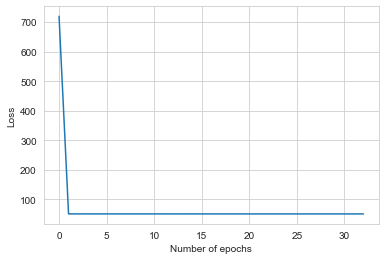

In [13]:
# 4 线性回归预测歌曲的年份

# 用于保存代价函数的历史记录
old_stdout = sys.stdout
sys.stdout = mystdout = StringIO()

# 模型训练
#################################### Question 4 #############################################
# 要求：
#    - 为lin_reg确定合适的参数，并拟合x_train, y_train进行训练
#    - 使用sklearn.linear_model.SGDRegressor()
#    - 参数verbose应设为1，以遍绘制代价函数的下降
################################ Start of Your Code #########################################
lin_reg=linear_model.SGDRegressor(verbose=1)
lin_reg.fit(x_train,y_train)
################################# End of Your Code ##########################################

# 得到代价函数的历史记录
sys.stdout = old_stdout
loss_history = mystdout.getvalue()
loss_list = []
for line in loss_history.split('\n'):
    if len(line.split("loss: ")) == 1:
        continue
    loss_list.append(float(line.split("loss: ")[-1]))

print('迭代次数:', len(loss_list))

# 代价函数下降的可视化
plt.figure()
plt.plot(np.arange(len(loss_list)), loss_list)
plt.xlabel("Number of epochs")
plt.ylabel("Loss")

- 得到训练好的线性回归模型之后，下面评估其预测结果
    - 分别在训练集、测试集上评估模型预测值的准确率和均方误差
        - 计算准确率时，不能以完全相等作为相等，应该给定一个范围。
        - 本题中，当预测值与真实值的偏差小于等于5时，认为预测准确。
            - 譬如，若真实年份为2000年，预测年份为1995~2005之间都算作预测准确。
        - ***均方误差（Mean square error, MSE）***也可以作为评价标准
    - 然后从训练集、测试集上分别抽取一些样本，直观对比的它们真实值和预测值

In [14]:
################################## Question 5 ########################################
# 要求：完成函数evaluate_model()，使其具备下面的功能。
#   - 功能：得到一个模型在一个数据集上的准确率和均方差
#     - 注：本题中，对某一样本，当预测值与实际值相差不大于5时，认为预测准确。
#   - 参数：
#     - model：要评估的模型
#     - X: 数据集的特征
#     - y：数据集的标签
#   - 返回值：
#     - 返回值1：准确率
#     - 返回值2：均方误差
# 提示：
#   - 准确率的计算可以借助sklearn.metrics.accuracy_score()方法
#   - 均方差的计算可以借助sklearn.metrics.mean_squared_error()方法
#   - 上面提到的两种方法只是一种可能的实现，并不是一定要用到
############################## Start of Your Code #####################################
def evaluate_model(model,X,y):
    y_predict=model.predict(X)
    MSE=sklearn.metrics.mean_squared_error(y,y_predict)
    for i in range(len(y)):
        if abs(y_predict[i]-y.values[i])<=5:
            y_predict[i]=y.values[i]
        else:
            y_predict[i]=int(y_predict[i])
    correctness=sklearn.metrics.accuracy_score(y,y_predict)
    return correctness, MSE
################################ End of Your Code #####################################

# 训练集准确率和均方差
accuracy_rate_lr_train, mse_lr_train = evaluate_model(lin_reg, x_train, y_train)
print('模型训练准确率为:', accuracy_rate_lr_train)
print('模型训练均方误差为:', mse_lr_train)

# 测试集准确率和均方差
accuracy_rate_lr_test, mse_lr_test = evaluate_model(lin_reg, x_test, y_test)
print('模型测试准确率为:', accuracy_rate_lr_test)
print('模型测试均方误差为:', mse_lr_test)

模型训练准确率为: 0.4600390325954519
模型训练均方误差为: 101.04923960288578
模型测试准确率为: 0.4611078830137517
模型测试均方误差为: 99.3861465346358


训练集样本的原始标签:
 [2003 2006 2005 1980 1994 2008 1997 2002 2000 2005]
训练集样本的预测结果:
 [2003.53043214 2005.19666095 1999.64750298 1996.04810937 1999.38078833
 1998.8930145  1996.91937347 1999.22511841 2000.83579345 2000.96101485]


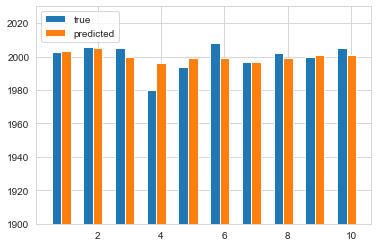

-------------------------------------------
测试集样本的原始标签: [1995 1975 2002 2001 2007 1998 2003 2007 1984 2007]
测试集样本的预测结果: [1992.89170437 1994.85323921 2001.27629518 1998.5664121  2000.11962496
 1999.4967594  2003.06213822 1992.84890858 1997.37994633 2000.23488555]


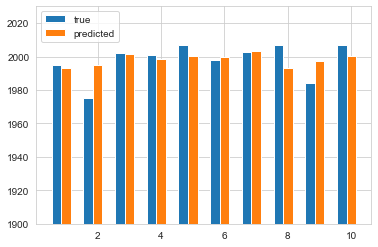

In [15]:
def barplot(true, pred, yi=None, ym=None):
    """
    用于绘制柱状图以对比真实值和预测值的函数
    yi: 纵坐标的下限
    ym: 纵坐标的上限
    """
    width=0.3;
    x = np.array([x for x in range(1,len(true)+1)]); # 第一个数据序列x轴
    x1 = x - width; # 为使其并列，使得第一个x轴序列全部减去条宽度
    plt.bar(x1,true,width=width, label='true');
    plt.bar(x,pred,width=width, label='predicted');
    plt.legend(loc='upper left'); # 设置标签显示在左上角
    if yi and ym:
        plt.ylim(yi,ym);
    plt.show();
    
    
# 针对训练数据集，对比预测值和实际值
samples_x_train, samples_y_train = shuffle(x_train, y_train, n_samples=10, random_state=0)  # 从训练集中随机选取10个样本
predicted_train = lin_reg.predict(samples_x_train)
print('训练集样本的原始标签:\n', samples_y_train.values)
print('训练集样本的预测结果:\n', predicted_train)
barplot(samples_y_train, predicted_train, 1900, 2030)
print('-------------------------------------------')

# 针对测试数据集，展示预测效果
samples_x_test, samples_y_test = shuffle(x_test, y_test, n_samples=10, random_state=0)
predicted_test = lin_reg.predict(samples_x_test)
print('测试集样本的原始标签:', samples_y_test.values)
print('测试集样本的预测结果:', predicted_test)
barplot(samples_y_test, predicted_test, 1900, 2030)

### 对比模型对于训练数据集和测试数据集的预测结果
- 可以看到，模型对测试集的预测效果往往不如训练集的效果。
- 如果训练集训练出来的模型也能很好地预测测试集的数据，那么这个模型的**泛化**能力就好。

# 五. 多项式回归
## 1. 多项式回归介绍
- **多项式回归**
    - 不再使用单纯的线性函数去拟合数据，而是使用一个多项式函数。
    - 例如，一个二次多项式：
    $$P_2(x)=\theta^T[1,x_1,x_2,x_1^2,x_2^2]$$
    - 会拓展数据集特征空间的维度
- 当线性回归效果不好时，即***欠拟合***时，需要尝试多项式回归
    - 欠拟合：当模型在训练集中表现不好时，自然更不会在测试数据中表现得好。这种情况就是欠拟合。
    
## 2. 交互项
- 多项式回归中可以增加***交互项***
- 什么是交互项
    - 例如，在二次多项式$P(x)=\theta^T[1,x_1,x_2,x_1^2,x_1x_2,x_2^2]$中，$x_1x_2$就是交叉项
- 以本课问题为例，如果某一音乐家在某一年代倾向于创作较长的音乐，另一时间段倾向于创作较短的音乐。这种情况下，可以增加创作者这一特征和音乐时长这一特征的交互项，帮助模型拟合
    - 我们这里并没有这么做，因为选取的特征并不符合这一特征

In [16]:
# 5 使用多项式回归训练模型

# 多项式数据准备
#################################### Question 6 #############################################
# 要求：
#   - 将X中的数据转化成三次多项式的数据
#   - 再将转化好的数据进行标准化、数据划分，得到poly_x_train, poly_x_test，类型：DataFrame
#      - 数据划分的比例仍应该按照Question 3的要求
# 提示：
#   - 使用sklearn.preprocessing.PolynomialFeatures()进行转化
#   - 如果计算机的性能很差，可以只使用二次多项式（一般来说都是可以的）
################################ Start of Your Code #########################################
poly=preprocessing.PolynomialFeatures(degree=3)#构造的方式就是特征与特征相乘(二次)
x_poly=poly.fit_transform(X)#训练数据生成学习模型参数+将其应用于模型以生成转换数据集
x_poly_scaled=pd.DataFrame(preprocessing.scale(x_poly))
poly_x_train,poly_x_test,y_train,y_test=sklearn.model_selection.train_test_split(x_poly_scaled,Y,test_size=0.1001853127516518)
################################# End of Your Code ##########################################
print(poly_x_train.shape)
print(poly_x_test.shape)

(463715, 455)
(51630, 455)


326


Text(0, 0.5, 'Loss')

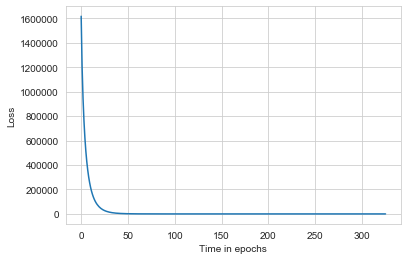

In [23]:
# 用于保存代价函数的历史记录
old_stdout = sys.stdout
sys.stdout = mystdout = StringIO()

# 模型训练
#################################### Question 7 #############################################
# 要求：
#    - 为pol_reg确定合适的参数，并拟合poly_x_train, y_train进行训练
#    - 使用sklearn.linear_model.SGDRegressor()
#    - 参数verbose应设为1，以遍绘制代价函数的下降
################################ Start of Your Code #########################################
pol_reg=linear_model.SGDRegressor(verbose=1,eta0=8e-6)
pol_reg.fit(poly_x_train,y_train)
################################# End of Your Code ##########################################

# 得到代价函数的历史记录
sys.stdout = old_stdout
loss_history = mystdout.getvalue()
loss_list = []
for line in loss_history.split('\n'):
    if(len(line.split("loss: ")) == 1):
        continue
    loss_list.append(float(line.split("loss: ")[-1]))

print(len(loss_list))

# 代价函数下降的可视化
plt.figure()
plt.plot(np.arange(len(loss_list)), loss_list)
plt.xlabel("Time in epochs")
plt.ylabel("Loss")

模型训练准确率为: 0.4888778667931812
模型训练均方误差为: 94.41957001725663
模型测试准确率为: 0.48770094906062367
模型测试均方误差为: 93.62687473680657
-------------------------------------------
训练集样本的原始标签: [2007 1950 1997 1999 2002 1995 2004 2004 1978 2008]
训练集样本的预测结果: [2000.53846598 1988.91756468 2001.81209003 1999.8262729  2004.78917672
 1997.56728781 1998.08651534 1996.84141364 1998.656383   1996.13837884]


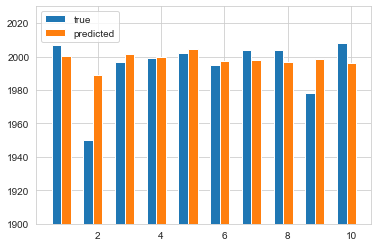

-------------------------------------------
测试集样本的原始标签: [1992 1980 2002 2007 1998 2008 2006 2008 2009 2003]
测试集样本的预测结果: [1994.72421801 1996.42551747 1996.78702554 1997.68928755 1996.15671163
 2003.0593868  1994.12277168 1998.44612462 1996.16253375 2004.73988783]


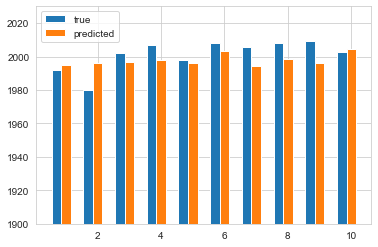

In [22]:
# 训练集准确率和均方差
accuracy_rate_pr_train, mse_pr_train = evaluate_model(pol_reg, poly_x_train, y_train)
print('模型训练准确率为:', accuracy_rate_pr_train)
print('模型训练均方误差为:', mse_pr_train)

# 测试集准确率和均方差
accuracy_rate_pr_test, mse_pr_test = evaluate_model(pol_reg, poly_x_test, y_test)
print('模型测试准确率为:', accuracy_rate_pr_test)
print('模型测试均方误差为:', mse_pr_test)

print('-------------------------------------------')

# 针对训练数据集，展示预测效果
samples_poly_x_train, samples_y_train = shuffle(poly_x_train, y_train, n_samples=10, random_state=0)
poly_predicted_train = pol_reg.predict(samples_poly_x_train)
print('训练集样本的原始标签:', samples_y_train.values)
print('训练集样本的预测结果:', poly_predicted_train)
barplot(samples_y_train, poly_predicted_train, 1900, 2030)
print('-------------------------------------------')

# 针对测试数据集，展示预测效果
samples_poly_x_test, samples_y_test = shuffle(poly_x_test, y_test, n_samples=10, random_state=0)
poly_predicted_test = pol_reg.predict(samples_poly_x_test)
print('测试集样本的原始标签:', samples_y_test.values)
print('测试集样本的预测结果:', poly_predicted_test)
barplot(samples_y_test, poly_predicted_test, 1900, 2030)

- 使用多项式回归可以解决欠拟合的问题，但又可能带来过拟合
    - ***过拟合***：指模型可以非常好地拟合训练数据，预测测试集时却表现很差
    
### 理解欠拟合与过拟合
例如我们想要拟合下面的数据
<img src="data.png" width="400" hegiht="300" align=center />
- 如果采用线性回归，那么拟合效果显然不好，数据距离拟合曲线较远
- 采用二次多项式回归，拟合效果刚刚好
- 采用100次多项式回归，虽然貌似拟合几乎每一个数据，但是丢失了信息规律，显然不能很好地预测未知的数据

![underfitvsoverfit](under&overfit.png)

# 六. 岭回归
## 1. 正则化
- 正如上面过拟合的例子显示，当模型**复杂度**高（比如参数很多）的时候，很容易出现过拟合。
    - 训练集误差很低，测试集表现较差——模型的泛化能力较差。
- ***正则化(Regularization)*** 是一种减少**测试**误差的手段。
    - 我们试图拉伸函数曲线使之更加平滑
    - 为了拉伸曲线，也就要弱化一些高阶项（曲线曲折的罪魁祸首）
    - 为此，我们想要降低高阶项的系数$\theta_i$大小——这叫做**惩罚**
- 做法：
    - 设模型的代价函数是$L(\theta)$，而我们的惩罚项是$R(\theta)$
    - 那么，将目标函数写为$J(\theta)=L(\theta)+\alpha R(\theta)$，再最小化目标函数即可
    - 其中$\alpha$是一个超参数，它决定了正则化惩罚的“力度”。$\alpha$越大，惩罚“力度”越大。
    
## 2. 岭回归
- ***岭回归***是一种常用的正则化线性回归。
    - 使用线性回归的代价函数，而惩罚项$R(\theta)=\sum\limits_{i=1}^{n}\theta_i^2$
    - 也就是目标函数写为：
    $$J(\theta)=L(\theta)+\alpha\sum\limits_{i=1}^{n}\theta_i^2$$
- 惩罚项的含义是空间中参数点$\theta$到原点的**欧式距离**的平方
    - 因此惩罚的效果是迫使参数点靠近原点，也就是迫使参数变小。
- 可以降低模型的复杂度，提高模型的泛化能力，即模型适用于新的数据集的能力

In [18]:
# 使用岭回归训练模型
# 模型训练
#################################### Question 8 #############################################
# 要求：
#   - 确定ridge_reg的参数，使用sklearn.linear_model.Ridge()
#   - 用多项式数据，即poly_x_train, y_train来训练ridge_reg
################################ Start of Your Code #########################################
ridge_reg=sklearn.linear_model.Ridge(alpha=0.01)
ridge_reg.fit(poly_x_train,y_train)
################################# End of Your Code ##########################################

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

- 预测数据是否会符合我们预期，波动变小呢？

模型训练准确率为: 0.5023840074183497
模型训练均方差为: 92.55768898990215
-------------------------------------------
模型测试准确率为: 0.5023242300987798
模型测试均方差为: 91.6112310456402
-------------------------------------------
训练集样本的原始标签: [2007 1950 1997 1999 2002 1995 2004 2004 1978 2008]
训练集样本的预测结果: [2000.37015919 1989.26927379 2002.27952232 1999.46586499 2005.56022436
 1999.16885618 1998.13044615 1996.35353828 1998.64844169 1996.00078708]


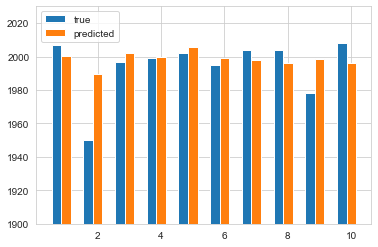

-------------------------------------------
测试集样本的原始标签: [1992 1980 2002 2007 1998 2008 2006 2008 2009 2003]
测试集样本的预测结果: [1994.99635845 1995.72982631 1997.71168631 1997.6170001  1995.41460297
 2004.3834426  1994.54290501 1999.21062394 1996.34937998 2005.38994455]


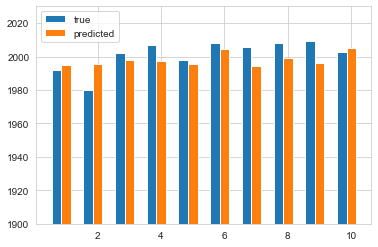

In [20]:
# 训练集准确率和均方差
accuracy_rate_rr_train, mse_rr_train = evaluate_model(ridge_reg, poly_x_train, y_train)
print('模型训练准确率为:', accuracy_rate_rr_train)
print('模型训练均方差为:', mse_rr_train)
print('-------------------------------------------')

# 测试集准确率和均方差
accuracy_rate_rr_test, mse_rr_test = evaluate_model(ridge_reg, poly_x_test, y_test)
print('模型测试准确率为:', accuracy_rate_rr_test)
print('模型测试均方差为:', mse_rr_test)
print('-------------------------------------------')

# 针对训练数据集，展示预测效果
samples_x_train, samples_y_train = shuffle(poly_x_train, y_train, n_samples=10, random_state=0)
predicted_train = ridge_reg.predict(samples_x_train)  # 做预测
print('训练集样本的原始标签:', samples_y_train.values)
print('训练集样本的预测结果:', predicted_train)
barplot(samples_y_train, predicted_train, 1900, 2030)
print('-------------------------------------------')

# 4.3.2 针对测试数据集，展示预测效果
samples_x_test, samples_y_test = shuffle(poly_x_test, y_test, n_samples=10, random_state=0)
predicted_test = ridge_reg.predict(samples_x_test)
print('测试集样本的原始标签:', samples_y_test.values)
print('测试集样本的预测结果:', predicted_test)
barplot(samples_y_test, predicted_test, 1900, 2030)

### 线性回归、多项式回归、岭回归模型的表现差异
- 对比三个模型对于测试集的预测准确率、均方差
    

In [21]:
data_present=[['线性回归', '训练集', accuracy_rate_lr_train, mse_lr_train],
    ['线性回归', '测试集', accuracy_rate_lr_test, mse_lr_test],
    ['多项式回归', '训练集', accuracy_rate_pr_train, mse_pr_train],
    ['多项式回归', '测试集', accuracy_rate_pr_test, mse_pr_test],
    ['岭回归', '训练集', accuracy_rate_rr_train, mse_rr_train],
    ['岭回归', '测试集', accuracy_rate_rr_test, mse_rr_test]]

# 使用PrettyTable做一个表格
table = pt.PrettyTable()
table.field_names = ["模型", "数据集", "准确率", "均方差"]
for row in data_present:
    table.add_row(row)
print(table)

+------------+--------+---------------------+--------------------+
|    模型    | 数据集 |        准确率       |       均方差       |
+------------+--------+---------------------+--------------------+
|  线性回归  | 训练集 |  0.4600390325954519 | 101.04923960288578 |
|  线性回归  | 测试集 |  0.4611078830137517 |  99.3861465346358  |
| 多项式回归 | 训练集 |  0.4888778667931812 | 94.41957001725663  |
| 多项式回归 | 测试集 | 0.48770094906062367 | 93.62687473680657  |
|   岭回归   | 训练集 |  0.5023840074183497 | 92.55768898990215  |
|   岭回归   | 测试集 |  0.5023242300987798 |  91.6112310456402  |
+------------+--------+---------------------+--------------------+
